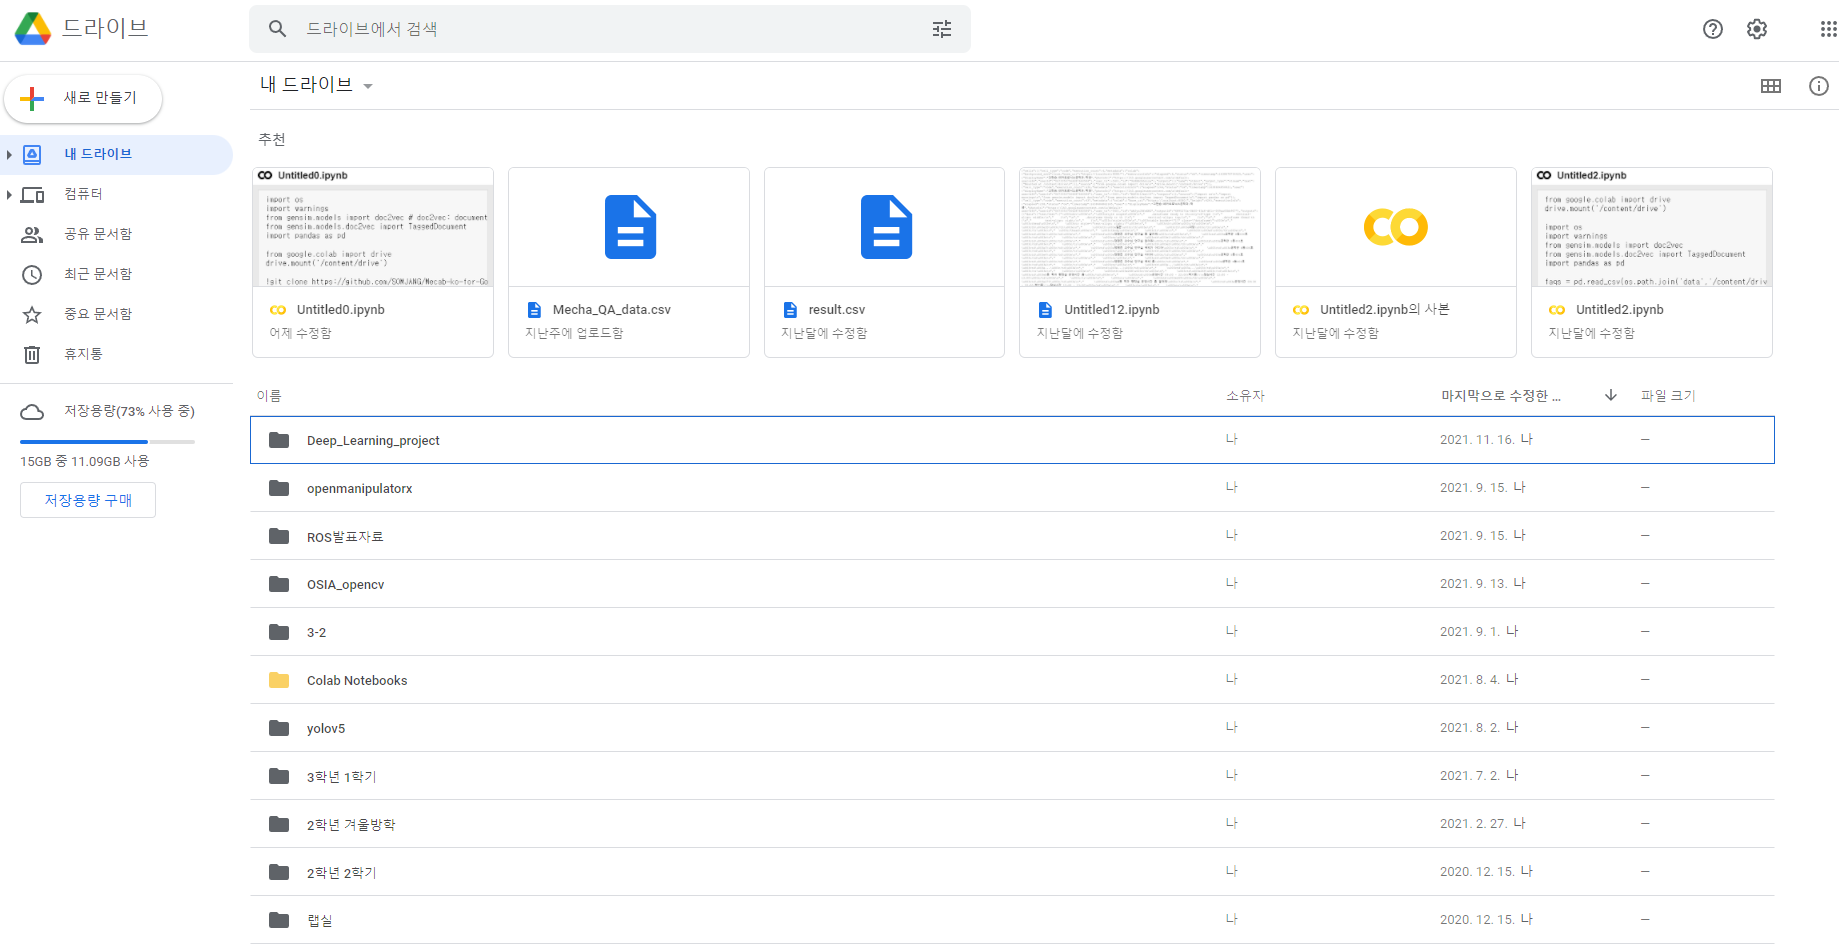

In [1]:
from google.colab import drive   #Google Drive와 연동하기 위한 패키지 설치. 
drive.mount('/content/drive')     #사용자 Google Drive 폴더에 마운트 하여서 데이터셋을 가져오기 위함.

Mounted at /content/drive


# **한글 형태소 분석과 품사 태깅을 위해 클래스를 비교할 필요가 있다.**
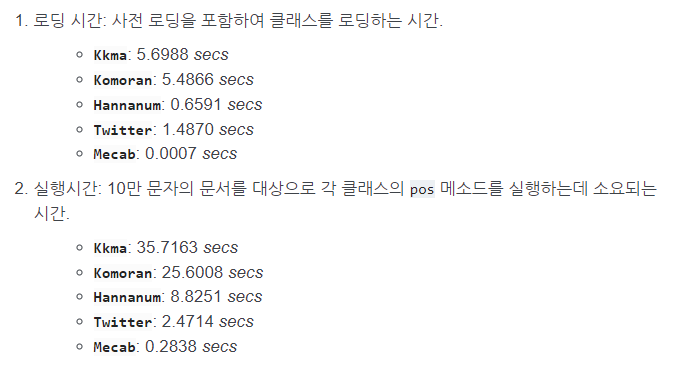

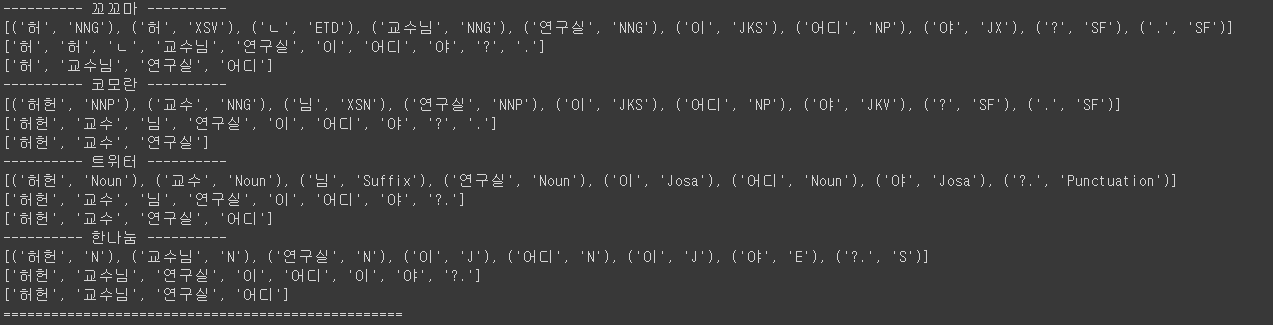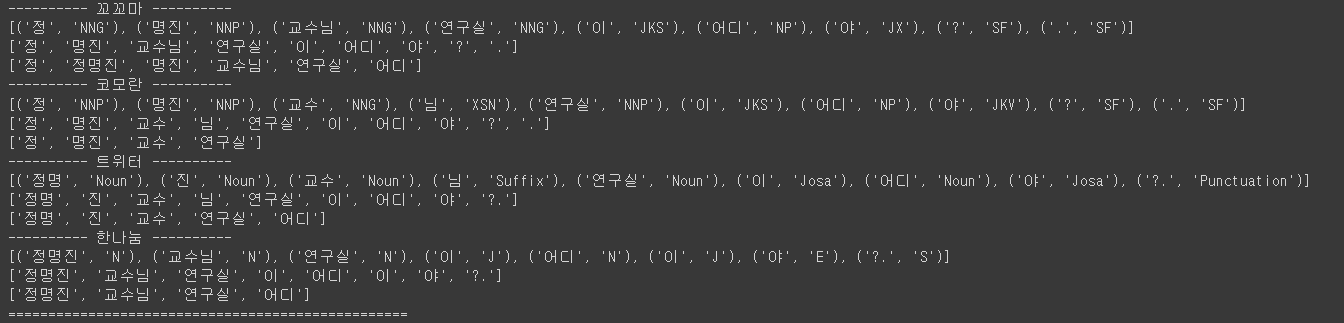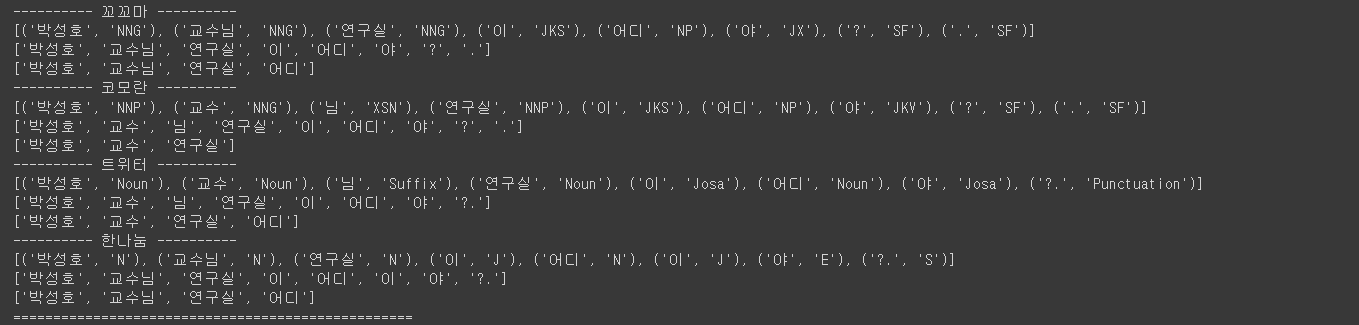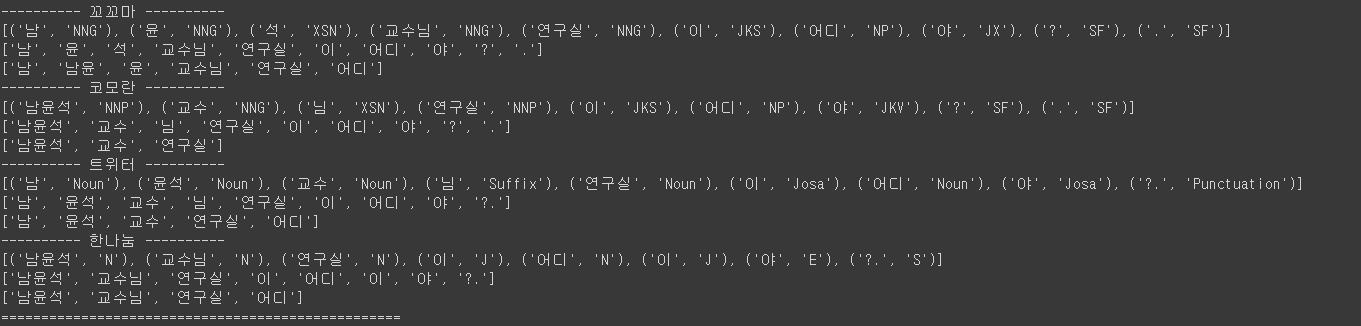

In [2]:
 #Colab환경에서 Mecab을 사용하기 위해 git clone 명령어를 사용하여 패키지를 설치하여 준다.
 #해당 깃에 들어가면 Colab에서 Mecab-ko-dic를 쉽게 설치할 수 있도록 가이드가 되어있습니다.
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git   

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (91/91), done.


시스템 플로우

1.   메카트로닉스 학부생들이 자주 하는 질문들을 Konlpy 중 속도가 가장 빠른 Mecab을 사용하고, 명사만 추출하여 토큰화 한다.
2.   토큰화가 완료된 질문들은 Gensim 패키지에 있는 doc2vec 클래스를 이용하여 수치화(벡터화)를 한다.

3.   입력한 질문과 가장 유사한 질문이 나오도록 한다.




In [3]:
! sudo bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 66.8 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-12-14 18:52:41--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22c5:2ef4, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=6kS6%2BaEGdXYlj%2F6qGBufbMEZCNs

### **사용된 라이브러리와 모듈에 관한 설명**!
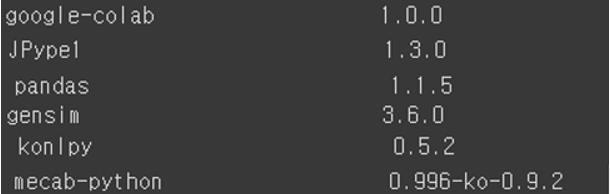

In [4]:
from konlpy.tag import Mecab  #konlpy.tag에서 Mecab을 가져온다.  -> 토큰화와 명사 추출을 위해서 사용할 에정.

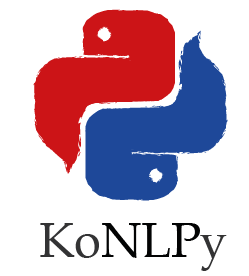
## **KoNLPy**


*   KoNLPy란 쉽고 간결한 한국어 정보처리 파이썬 패키지로 korean natural language processing in python의 약자다.
*   파이썬의 한국어 자연어 처리 패키지이다.
*   실용적 작업이 들어가기 전에 품사를 태깅하기 위해 POS도 사용한다.
*   KoNLPy는 다음과 같은 다양한 형태소 분석, 태깅 라이브러리를 파이썬에서 쉽게 사용할 수 있도록 모아놓았다.
      -   Hannanum: 한나눔. KAIST Semantic Web Research Center 개발.
      -   Kkma: 꼬꼬마. 서울대학교 IDS(Intelligent Data Systems) 연구실 개발.

      - Komoran: 코모란. Shineware에서 개발.

      - Mecab: 메카브. 일본어용 형태소 분석기를 한국어를 사용할 수 있도록 수정.

      - Open Korean Text: 오픈 소스 한국어 분석기. 과거 트위터 형태소 분석기.  



In [5]:
from gensim.models import doc2vec # Gensim패키지 내부에 doc2vec이라는 클래스를 사용. Document To Vector 텍스트를 수치화 하기 위해 사용.
from gensim.models.doc2vec import TaggedDocument #gensim.models.doc2vec에서 TaggedDocument를 가져온다. -> 문서 태깅을 위해서 사용할 예정

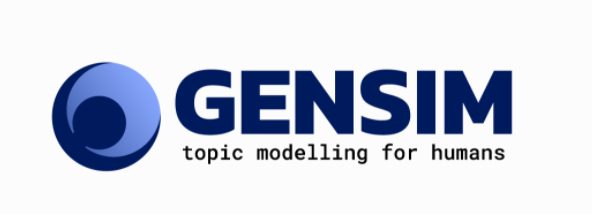
## **GENSIM**


*   Gensim은 문서를 의미 벡터로 최대한 효율적으로 표현하기 위한 무료 오픈 소스 파이썬 라이브러리이다.
*    Gensim의 알고리즘 은 학습 문서 말뭉치 내에서 통계적 동시 발생 패턴을 검사하여 문서의 구조를 자동으로 발견합니다. 
*   Gensim에서 제공해주는 doc2vec과 유사도 검사를 수행하기 위해서 사용




In [6]:
import os
import pandas as pd

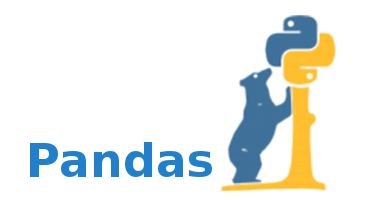

## **Pandas**


*  Pandas는 쉽고 직관적인 관계형 또는 분류된 데이터로 작업 할 수 있도록 설계된 
빠르고 유연하며 표현이 풍부한 데이터 구조를 제공하는 Python 패키지이다.
*    Pandas는 다음의 종류의 데이터에 적합한 분석 패키지이다.
  - Python 자료구조와의 호환(List ,Tuple, Dict, NumpyArray 등)
  - 큰 데이터의 빠른 Indexing, Slicing, Sorting 하는 기능
  - 두 데이터 간의 Join(행,열 방향) 기능
  - 데이터의 피봇팅 및 그룹핑
  - 데이터의 통계 및 시각화 기능
  - 외부 데이터를 입력 받아 Pandas 자료구조로 저장 및 출력(CSV, 구분자가 있는 txt, 엑셀데이터, SQL database, XML 등)




In [7]:
mecab = Mecab() # Mecab 사용을 위해 mecab 객체 만들어 놓는다. 편하게 사용하기 위해서.

text = u"""박성호 교수님 연구실 위치좀 알려줘.""" 
nouns = mecab.nouns(text)    #명사만 추출한 결과를 보여준다.
print(nouns)

['박성호', '교수', '연구실', '위치']


# 구글 드라이브에 저장되어 있는 Q&A데이터 셋을 불러온다. 
encoding='cp949'는 에러 때문
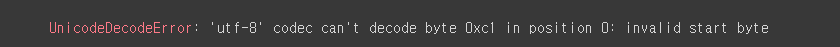
위 에러는 한글이 포함된 csv 파일이나 텍스트 파일을 read_csv로 불러올 때 뜨는 오류이다.
따라서 encoding 인자에 한글 전용 인코딩 방식인 **'ecu-kr'** 또는 **'cp=949'**를 입력해준다.

In [17]:
faqs = pd.read_csv(os.path.join('data','/content/drive/My Drive/Mecha_QA_data_2123_rand.csv'))
faqs

,ID,질문,대답
0,1961,기계요소설계에 대해 알려주세요,전공선택\n자동화 기구 시스템을 설계할 때 고려해야 하는 각종 요소들의 설계방법과 ...
1,1092,메카 추천 부전공이 뭐뭐있어?,"스마트팩토리, 인공지능융합,지능형로봇융합"
2,1859,C프로그래밍1은 뭘 배우나요?,"기초필수(전공)\n기본적인 C 프로그래밍 언어 문법을 학습하고, 실습을 통해 프로그..."
3,1981,동역학에 대해 알려주면 감사하겠습니다,"전공선택\n설계 대상인 기계나 기구에 어떤 힘이 가해질 때, 변위나 속도가 어떻게 ..."
4,36,이석원 교수님 연구실 좀 알려줘,공학관 B동 407호
...,...,...,...
2118,1492,전기회로2는 뭐 가르치나요?,전공필수\n가정 및 산업용의 실용적인 교류회로를 이해한다. 교류회로에서 사용되는 부...
2119,532,강대진 교수님 이메일 뭐노,djkang@kpu.ac.kr
2120,1308,메카 랩실 뭐 있노?,지능메카트로닉스 EH\n마이크로/나노 자동화 시스템 EH\n차세대 정밀모터 시스템 ...
2121,1812,마이크로컴퓨터응용에 대해 알려주시오,"전공선택\n메모리, 입출력 장치 및 주변장치를 포함하는 교육용 원칩 마이크로컴퓨터 ..."


In [23]:
d2v_faqs = doc2vec.Doc2Vec.load(os.path.join('data','/content/drive/My Drive/mecha_qna.model')) #안되면 My Drive를 drive/뒤에 넣어보기

In [19]:
# 명사만 추출하여서 Doc2Vec을 활용하는게 더 접근하기 쉬운 방법이었다.
filter_mecab = ['NNG',  #보통명사  ->  일반적인 명사로만 추출하기 위해.
                'NNP',  #고유명사 -> 교수님 성함 같은 경우에는 고유명사로 취급
                'SL' ,  #외국어 -> 혹시나 연구실을 EH와 같이 질문 하거나, 과목의 이름 중 PC제어 응용, C언어 같이 영어가 들어가는 과목 때문에 추가 하였다.                                              
                'SN'    #숫자  -> 17학번, 1학년 과 같이 숫자 정보가 필요한 질문들에 대해서 알맞는 대답을 하기 위해 추가해 주었다.
               ]
def tokenize_mecab_noun(doc):    
    token_doc = ['/'.join(word) for word in mecab.pos(doc) if word[1] in filter_mecab]  #.join을 사용하여서 형태소로 나눈 단어의 품사를 위에 만든 filter_mecab을 통해 태깅해준다.
    return token_doc

### 한국어 품사 **태그표**
https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0
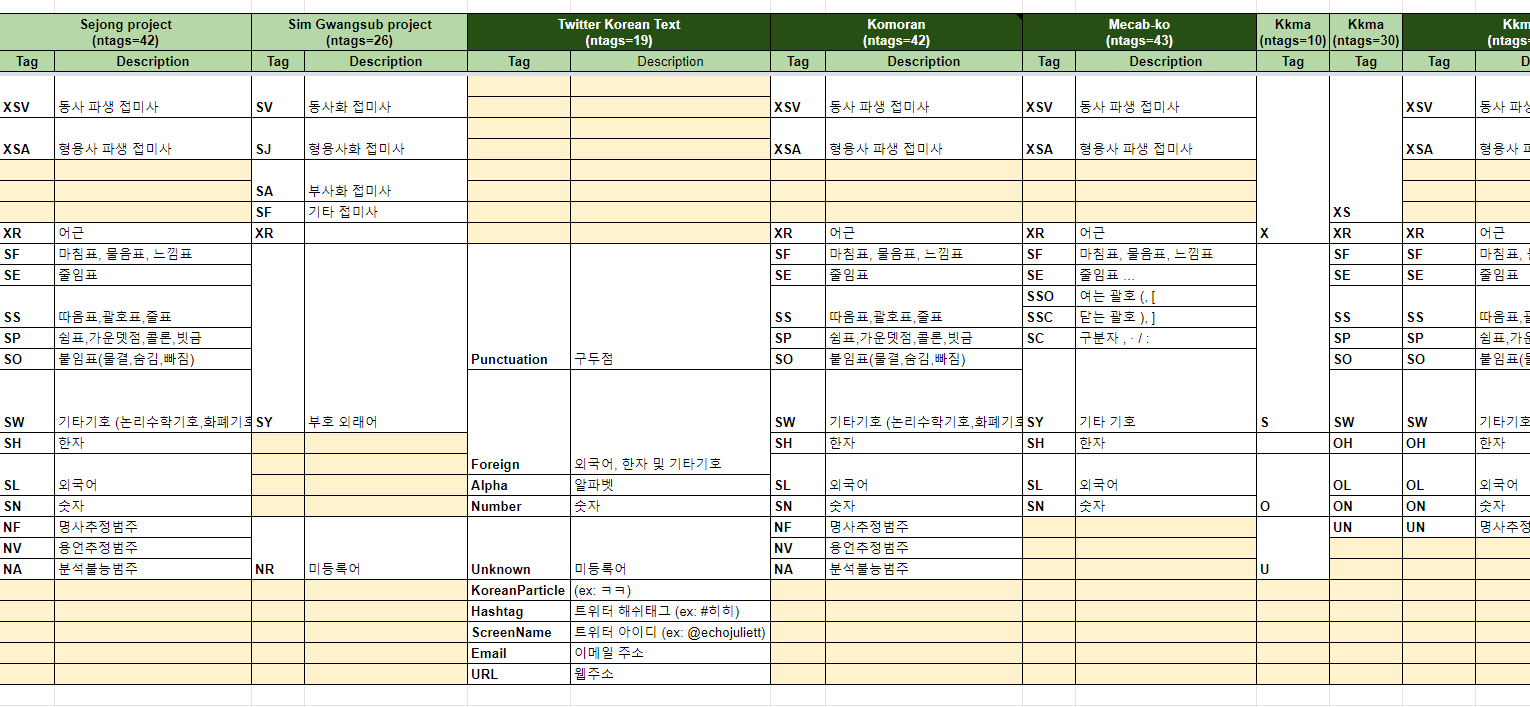

Doc2Vec(documents=None, corpus_file=None, vector_size=100, dm=1, dbow_words=0, dm_concat=0, dm_tag_count=1, trim_rule=None, callbacks=(), window=5, epochs=10, shrink_windows=True)


*   documents=    //(선택 사항) 문서를 제공하지 않으면 모델이 초기화 되지 않는 상태로 남습니다. 다른 방식으로 초기화 할 경우 사용. 주로 None
*   corpus_file=   /(str, 선택사항) sentence 객체를 만들어준다.
*   vector_size= ~   //(int, 선택사항) 특징 벡터의 차원 설정, 즉 임베딩 벡터의 크기. 벡터 사이즈가 클수록 생성된 모델의 성능이 정교해지나 훈련 시간 및 메모리의 크기가 커지는 단점이 있다. 이 파라미터는 데이터의 개수를 고려해야 한다.

*   dm_mean=None   // ({1, 0}, 선택사항) 0 이면 컨텍스트 단어 벡터의 합, 1이면 평균 상용 
*   dm=1   // ({1, 0}, 선택사항) 훈련 알고리즘 정의, 0인 경우 PV-DBOW 1인 경우 PV-DM사용
*  dbow_words=0  // ({1, 0}, 선택사항) 0이면 문서 벡터만 훈련(더 빠름),1이면 DBOW 문서 벡터 훈련과 동시에 단어 벡터(skip-gram) 방식으로 훈련
*   dm_concat=0   //({1, 0}, 선택사항) 1인 경우 벡터의 연결을 사용. 태그의 크기와 모든 단어가 함께 연결되기 때문에 더 큰 모델을 생성함
*   dm_tag_count=1   // (int, 선택사항) dm_concat모드를 사용할 때 문서당 예상되는 일정한 문서 태그 수
*   trim_rule=None   //(function 선택사항) 특정 단어가 어휘에 남아 있어야 하는지, 제거돼야 하는지, 기본 값을 사용하여 처리해야 하는지 지정한다.
*   callbacks=()   // 훈련 중 특정 단계에서 실행해야 하는 콜백 목록
*   window=5 (int , optional)  // 문장 내에서 현재 단어와 예측 단어 사이의 최대 거리
*   epochs=10 (int , optional) //말뭉치에 대한 반복 횟수. Default값은 10
*   shrink_windows=True (bool , optional)    // 4.1버전에 추가도니 실험적인 기능. 
[https://radimrehurek.com/gensim/models/doc2vec.html
API참고]









In [21]:
#test_string = "정명진 교수님 전화번호 알려줘"
#test_string = "17학번 필수 교양 알려줘"
#test_string = "사무실 학과 위치 어디야"
test_string = "심재홍 교수님 연구실 위치가 어디야?"
#test_string = "17학번 졸업 요건이 뭐야?"
tokened_test_string = tokenize_mecab_noun(test_string)
tokened_test_string

['심재홍/NNP', '교수/NNG', '연구실/NNG', '위치/NNG']

In [24]:
# 유사한 질문을 잘 찾는고 정확도 5위까지 확인하기

topn = 5 # 유사도 5위까지 출력
# 모델로 추측
test_vector = d2v_faqs.infer_vector(tokened_test_string)
result = d2v_faqs.docvecs.most_similar([test_vector], topn=topn)

for i in range(topn):
 
  if(result[i][1]>0.88):
    print("{}위. {}, {} {}".format(i+1, result[i][1], result[i][0], faqs['질문'][result[i][0]] ))
    
  elif(result[i][1]<0.88):
    print("잘못된 질문 입니다.")
    

1위. 0.9743033051490784, 1489 심재홍 교수님 연구실 위치가 어디야
2위. 0.9735879898071289, 1327 심재홍 교수님 연구실 위치가 어디오
3위. 0.9722902178764343, 1866 심재홍 교수님 연구실 위치 좀 알려줘
4위. 0.9711077809333801, 1071 심재홍 교수님 연구실 위치 좀
5위. 0.9254788756370544, 1609 심재홍 교수님 연구실 어디야
